# Análisis de Niveles de Obesidad
**Hipótesis:**
1. El consumo frecuente de alimentos calóricos (FAVC) está correlacionado con mayores niveles de obesidad.
2. La actividad física regular (FAF) reduce la probabilidad de obesidad.
3. El monitoreo de calorías (SCC) está asociado con menores niveles de sobrepeso.
4. El historial familiar de sobrepeso incrementa el riesgo de obesidad.

In [61]:
# %%
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                            classification_report, mean_squared_error)
from imblearn.over_sampling import SMOTE

## Análisis Exploratorio de Datos (EDA)

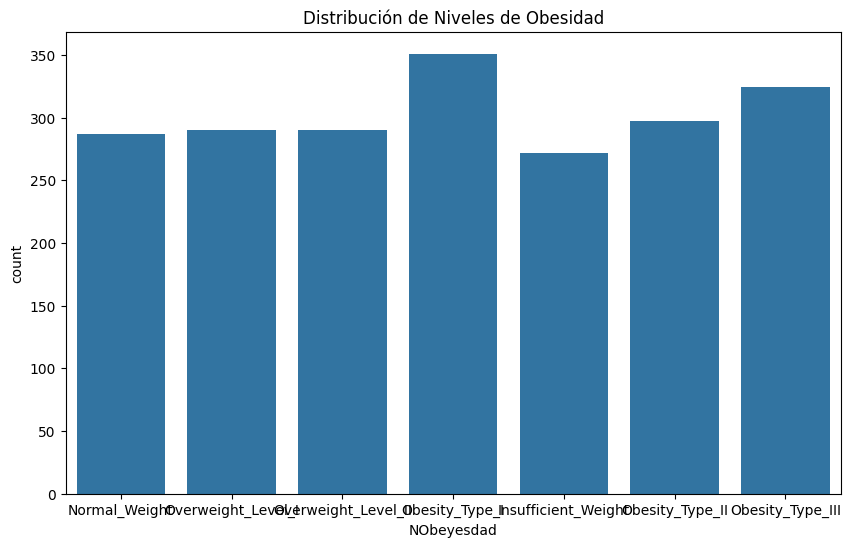

In [62]:
# %%
# Cargar datos
df = pd.read_csv("../data/ObesityDataSet.csv")

# Distribución de clases
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='NObeyesdad')
plt.title('Distribución de Niveles de Obesidad')
plt.show()

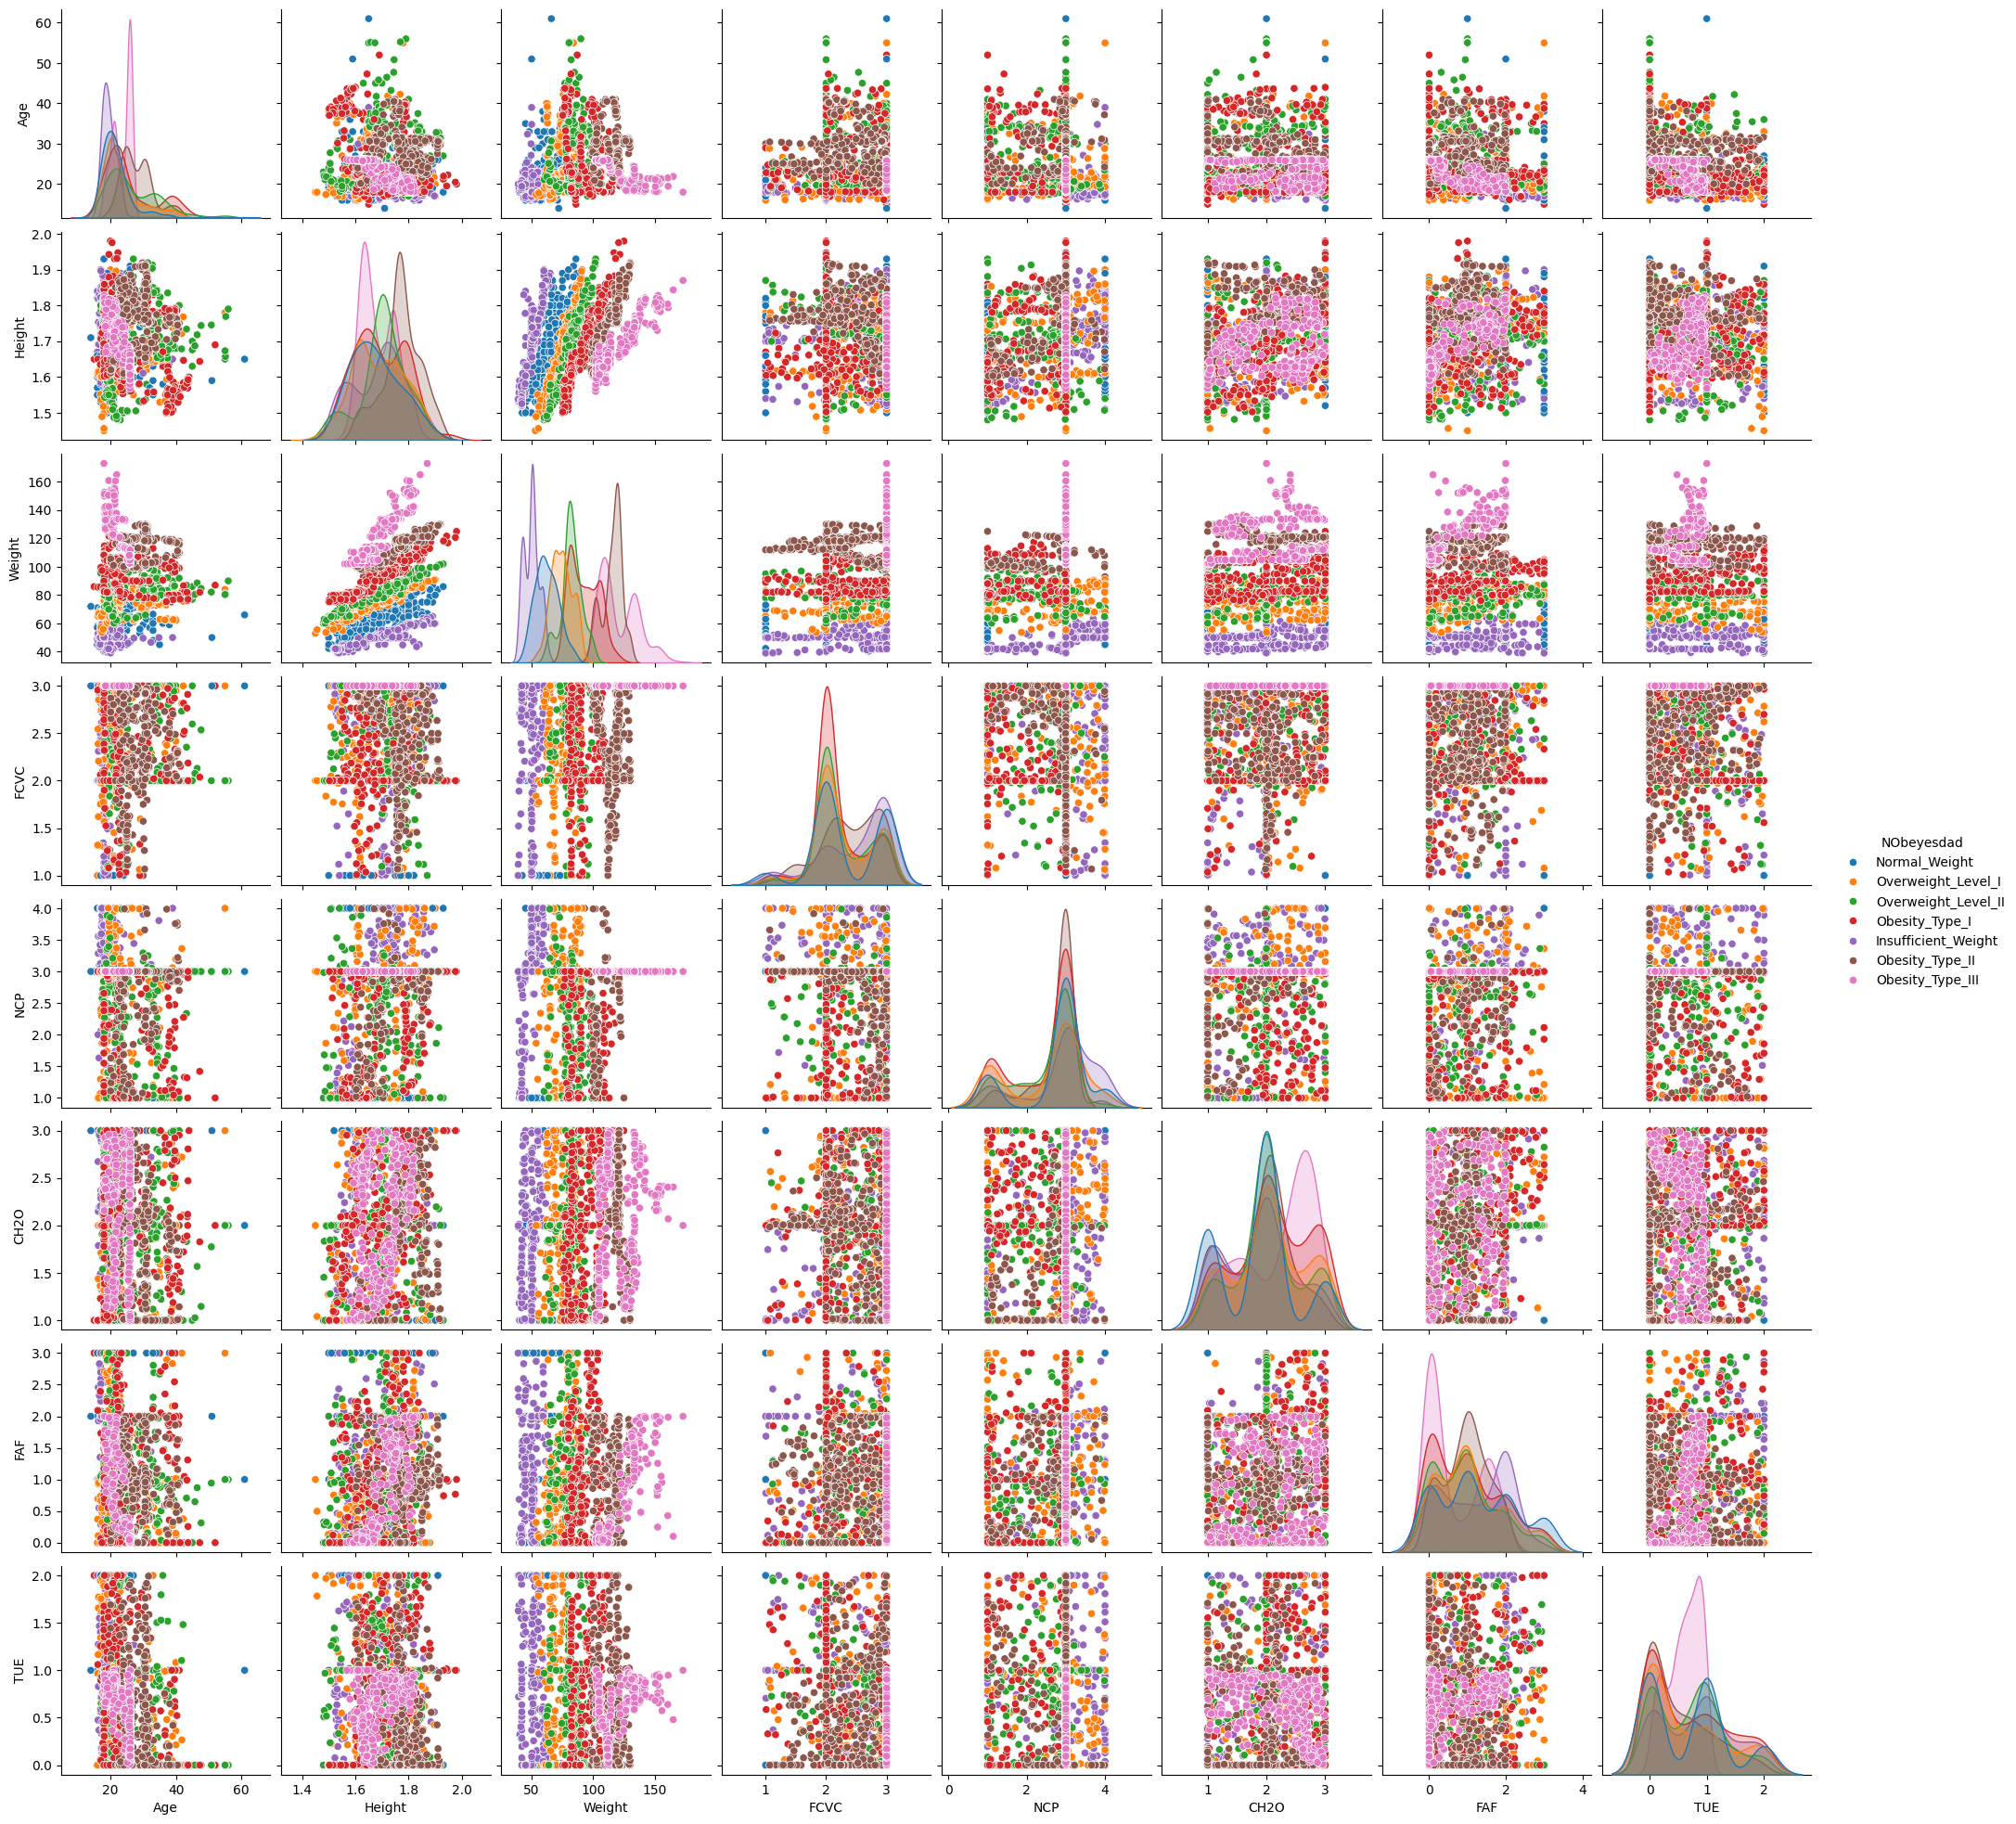

In [63]:
# %%
# Relación entre variables
num_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
sns.pairplot(df[num_cols + ['NObeyesdad']], hue='NObeyesdad')
plt.show()

In [64]:
# %%
# Codificación de variables categóricas
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 
                   'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# Balanceo de clases con SMOTE
X = df_encoded.drop('NObeyesdad', axis=1)
y = df_encoded['NObeyesdad']
X_res, y_res = SMOTE().fit_resample(X, y)

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=0.2, random_state=42)


## Entrenamiento de Modelos

In [65]:
# %%
# Configuración de modelos y parámetros
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']}
    },
    'SVM': {
        'model': SVC(),
        'params': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    }
}

# Entrenamiento y evaluación
results = {}
for name, config in models.items():
    grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)
    
    # Predicciones
    y_pred = grid.predict(X_test)
    
    # Métricas (solo las apropiadas para clasificación)
    results[name] = {
        'best_params': grid.best_params_,
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }

c:\Users\USUARIO\Documents\GitHub\Modelo\obesity-env\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\USUARIO\Documents\GitHub\Modelo\obesity-env\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\USUARIO\Documents\GitHub\Modelo\obesity-env\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\USUARIO\Documents\GitHub\Modelo\obesity-env\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\USUARIO\Documents\GitHub\Modelo\obesity-env\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did 

## Resultados y Evaluación

Mejor modelo: SVM


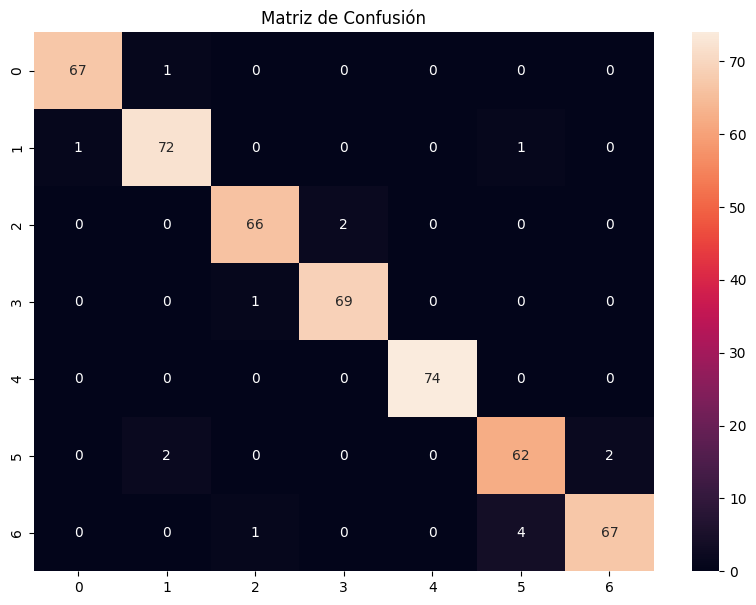

In [66]:
# %%
# Mejor modelo
best_model = max(results, key=lambda x: results[x]['accuracy'])
print(f"Mejor modelo: {best_model}")

# Matriz de confusión
plt.figure(figsize=(10,7))
sns.heatmap(results[best_model]['confusion_matrix'], annot=True, fmt='d')
plt.title('Matriz de Confusión')
plt.show()

In [67]:
# %%
# Reporte de métricas
print("Métricas clave:")
print(f"Precisión: {results[best_model]['accuracy']:.2f}")
print("\nReporte de clasificación completo:")
print(results[best_model]['classification_report'])

Métricas clave:
Precisión: 0.97

Reporte de clasificación completo:
                     precision    recall  f1-score   support

Insufficient_Weight       0.99      0.99      0.99        68
      Normal_Weight       0.96      0.97      0.97        74
     Obesity_Type_I       0.97      0.97      0.97        68
    Obesity_Type_II       0.97      0.99      0.98        70
   Obesity_Type_III       1.00      1.00      1.00        74
 Overweight_Level_I       0.93      0.94      0.93        66
Overweight_Level_II       0.97      0.93      0.95        72

           accuracy                           0.97       492
          macro avg       0.97      0.97      0.97       492
       weighted avg       0.97      0.97      0.97       492

